In [ ]:
import math
import numpy as np
# import random

# random.seed(1)

# Константы
N = 6                                                               # веществ
M = 5                                                               # реакций
A = np.array([100000000, 90000000, 85000000, 110000000, 95000000])
Ea= np.array([70000, 60000, 55000, 80000, 75000])
R = 8.314
T = 250
H = 0.01
MATR = np.array([
    [-2, -1, 1, 1, 0, 0],
    [0, -2, 1, 0, 2, 0],
    [0, -1, -2, 1, 0, 1],
    [1, 0, 0, -2, 1, 0],
    [1, 0, 0, 0, -2, 1]
])

MATR_PLUS = np.where(MATR < 0, -MATR, 0)

# Вычисление вектора коэффициентов скоростей химических реакций
# k = [0 for _ in range(M)]
# for i, k0_val in enumerate(A):
#     k[i] = k0_val * math.exp(-Ea[i] / (R * T)) * (T**0.5)

k = A * np.exp(-Ea / (R * T)) * (T**0.5)

# Переменные, будут заводиться отдельно для каждого цикла
vr_time = 10
# C = [1/N for _ in range(N)]
# F = [0 for _ in range(N)]
# W = [1 for _ in range(M)]
C = np.full(N, 1 / N)
F = np.zeros(N)
W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(len(A))])  # Скорость для каждой реакции

In [41]:
print(np.prod(C**MATR_PLUS.T[:, 0]))
print(k[0])
print(k[0]*np.prod(C**MATR_PLUS.T[:, 0]))

0.004629629629629629
3.738888937153229e-06
1.7309671005339023e-08


In [36]:
print(C)
print(k)
print(W)

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
[3.73888894e-06 4.13472031e-04 4.32865611e-03 3.34714238e-08
 3.20431822e-07]
[1.73096710e-08 1.14853342e-05 2.00400746e-05 9.29761773e-10
 8.90088393e-09]


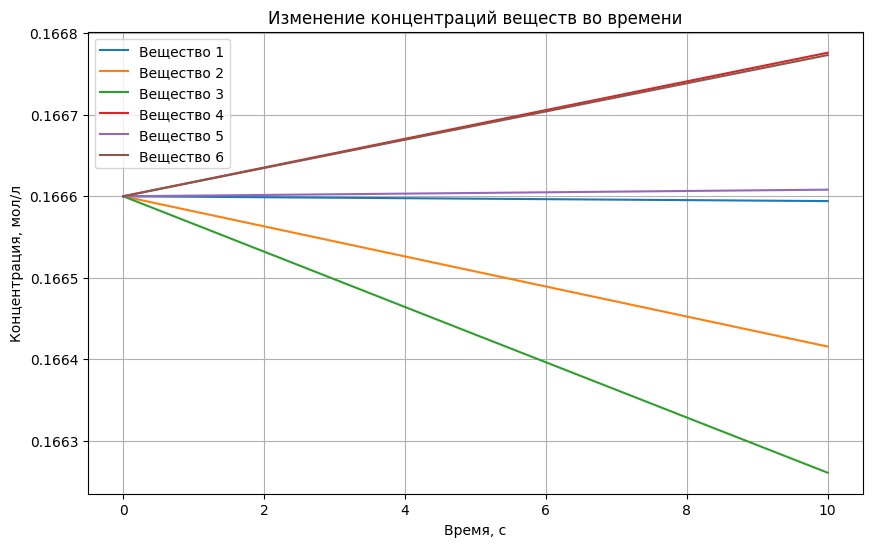

In [10]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Константы Аррениуса
A = np.array([100000000, 90000000, 85000000, 110000000, 95000000])  # предэкспоненциальный множитель
E = np.array([70000, 60000, 55000, 80000, 75000])  # энергия активации (Дж/моль)
R = 8.314  # универсальная газовая постоянная
T = 300  # температура (К)

# Стехиометрическая матрица
S = np.array([ 
    [-2, -1,  1,  1,  0,  0],
    [ 0, -2,  1,  0,  2,  0],
    [ 0, -1, -2,  1,  0,  1],
    [ 1,  0,  0, -2,  1,  0],
    [ 1,  0,  0,  0, -2,  1]
])

# Порядки реакций (матрица)
nu = np.array([
    [2, 1, 0, 0, 0, 0],  # Вещество 1
    [0, 2, 1, 0, 2, 0],  # Вещество 2
    [0, 1, 2, 0, 0, 1],  # Вещество 3
    [1, 0, 0, 2, 1, 0],  # Вещество 4
    [1, 0, 0, 0, 2, 1]   # Вещество 5
])

# Начальные концентрации
C0 = np.array([0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666])

# Вычисление скоростей реакций
def reaction_rates(C, T):
    k = A * np.exp(-E / (R * T))  # Вычисление констант скоростей
    r = np.array([k[j] * np.prod(C**nu.T[:, j]) for j in range(len(A))])  # Скорость для каждой реакции
    return r

# Дифференциальные уравнения
def dCdt(t, C):
    r = reaction_rates(C, T)  # Скорости реакций
    dC = S.T @ r  # Изменение концентраций
    return dC

# Численное решение
time_span = (0, 10)  # Время реакции (с)
time_points = np.linspace(0, 10, 1000)  # Точки для вывода
solution = solve_ivp(dCdt, time_span, C0, t_eval=time_points)

# Графики концентраций
plt.figure(figsize=(10, 6))
for i, C in enumerate(solution.y):
    plt.plot(solution.t, C, label=f'Вещество {i+1}')
plt.xlabel('Время, с')
plt.ylabel('Концентрация, мол/л')
plt.title('Изменение концентраций веществ во времени')
plt.legend()
plt.grid()
plt.show()


In [45]:
import math
import numpy as np
# import random

# random.seed(1)

# Константы
N = 6                                                               # веществ
M = 5                                                               # реакций
A = np.array([100000000, 90000000, 85000000, 110000000, 95000000])
Ea= np.array([70000, 60000, 55000, 80000, 75000])
R = 8.314
T = 250
H = 100
MATR = np.array([
    [-2, -1, 1, 1, 0, 0],
    [0, -2, 1, 0, 2, 0],
    [0, -1, -2, 1, 0, 1],
    [1, 0, 0, -2, 1, 0],
    [1, 0, 0, 0, -2, 1]
])

MATR_PLUS = np.where(MATR < 0, -MATR, 0)
k = A * np.exp(-Ea / (R * T)) * (T**0.5)

# Переменные, будут заводиться отдельно для каждого цикла
vr_time = 10
# C0 = np.full(N, 1 / N)
C = np.full(N, 1 / N)
print("Начальные концентрации:       ", C)

def dCdt(t, C):
    W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(M)])  # Скорость для каждой реакции
    dC = MATR.T @ W  # Изменение концентраций
    return dC

for i in range(vr_time * H):
    W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(M)])
    dC = MATR.T @ W
    C += dC



print("Концентрации после 10 секунд: ", C)

Начальные концентрации:        [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Концентрации после 10 секунд:  [0.16664686 0.13285153 0.14482574 0.18218251 0.18494495 0.18217914]


In [26]:
print(MATR)
print()
print(MATR.T)

[[-2 -1  1  1  0  0]
 [ 0 -2  1  0  2  0]
 [ 0 -1 -2  1  0  1]
 [ 1  0  0 -2  1  0]
 [ 1  0  0  0 -2  1]]

[[-2  0  0  1  1]
 [-1 -2 -1  0  0]
 [ 1  1 -2  0  0]
 [ 1  0  1 -2  0]
 [ 0  2  0  1 -2]
 [ 0  0  1  0  1]]


In [30]:
W = np.array([k[j] * np.prod(C**MATR_PLUS.T[:, j]) for j in range(M)])
print(W)

[1.73096710e-08 1.14853342e-05 2.00400746e-05 9.29761773e-10
 8.90088393e-09]


In [32]:
F = np.zeros(N)
print(F)

[0. 0. 0. 0. 0. 0.]


In [ ]:
for i in range(N):
    F[i] = sum(MATR.T[i] * W)
print(F)

print()
print(MATR.T @ W)


[-2.47886963e-08 -4.30280526e-05 -2.85775053e-05  2.00555247e-05
  2.29537964e-05  2.00489755e-05]

[-2.47886963e-08 -4.30280526e-05 -2.85775053e-05  2.00555247e-05
  2.29537964e-05  2.00489755e-05]

[-1.73096710e-08  1.14853342e-05 -2.00400746e-05  0.00000000e+00
  0.00000000e+00]


In [ ]:
for i in range(N):
    print(MATR.T[i] * W)
    print(sum(MATR.T[i] * W))
    print()

print()
print(MATR.T * W)



[-3.46193420e-08  0.00000000e+00  0.00000000e+00  9.29761773e-10
  8.90088393e-09]
-2.47886963056279e-08

[-1.73096710e-08 -2.29706684e-05 -2.00400746e-05  0.00000000e+00
  0.00000000e+00]
-4.302805262118975e-05

[ 1.73096710e-08  1.14853342e-05 -4.00801492e-05  0.00000000e+00
  0.00000000e+00]
-2.8577505309482196e-05

[ 1.73096710e-08  0.00000000e+00  2.00400746e-05 -1.85952355e-09
  0.00000000e+00]
2.005552472969103e-05

[ 0.00000000e+00  2.29706684e-05  0.00000000e+00  9.29761773e-10
 -1.78017679e-08]
2.2953796361861717e-05

[0.00000000e+00 0.00000000e+00 2.00400746e-05 0.00000000e+00
 8.90088393e-09]
2.0048975466163843e-05


[[-3.46193420e-08  0.00000000e+00  0.00000000e+00  9.29761773e-10
   8.90088393e-09]
 [-1.73096710e-08 -2.29706684e-05 -2.00400746e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.73096710e-08  1.14853342e-05 -4.00801492e-05  0.00000000e+00
   0.00000000e+00]
 [ 1.73096710e-08  0.00000000e+00  2.00400746e-05 -1.85952355e-09
   0.00000000e+00]
 [ 0.00000000e+00  2.29